In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#to generate same sequence of random numbers in whole file
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
#It is used during the training of a neural network to monitor a
# specified metric (typically a validation metric) and stop training
#  early if certain criteria are met. The purpose of using EarlyStopping
#  is to prevent overfitting and to save time and resources when further
#  training is unlikely to improve the model's performance.
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
import os
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
from google.colab import files
from IPython.display import Image as IPImage, display

In [ ]:
def convert_to_ela_image(path, quality):
    # creating a temporary filename for an intermediate image
    temp_filename = 'temp_file_name.jpg'
    # filename for ela image that will be generated
    ela_filename = 'temp_ela.png'

    # open image and convert to RGB
    image = Image.open(path).convert('RGB')

    # save image as jpg and keep quality as before
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    # calculate pixel difference between original image and RGB (new image)
    # which will represents areas of image that have been altered.
    ela_image = ImageChops.difference(image, temp_image)

    # calculating minimum and maximum pixel values in the images
    extrema = ela_image.getextrema()

    # finds the maximum difference value among the extrema. This value is used to scale the ELA image.
    max_diff = max([ex[1] for ex in extrema])

    # ensuring max_diff is not zero to avoid division by zero.
    if max_diff == 0:
        max_diff = 1

    # calculates a scaling factor based on the maximum difference value. This factor
    # is used to stretch the ELA image's pixel values across the full 0-255 range.
    scale = 255.0 / max_diff

    # enhances the brightness of the ELA image by applying the previously calculated
    # scaling factor for making the manipulated regions stand out more distinctly.
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [ ]:
def prepare_image(image_path, image_size=(128, 128)):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [ ]:
X=[]
Y=[]

In [ ]:
import random
path='/content/CASIA2/Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tif'):
            full_path = os.path.join(dirname,filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y)%500==0:
                print(f'Processing {len(Y)} images')
random.shuffle(X)
X=X[:2100]
Y=Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [ ]:
path = '/content/CASIA2/Tp'
#path = '/content/drive/MyDrive/Colab Notebooks/Image_Detector/CASIA2/Fake'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')
print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [ ]:
# converting X into array
X = np.array(X)
#used when you have a target variable (labels or classes) that is represented as integers and you want to convert it into a binary matrix format suitable for training machine learning models, especially neural networks.
# In Y there are two classes 1 for real and 0 for fake so to_categorical() converts this array into 2D array of labelled classes.
# this Y will look like [[1,0],[0,1]] for 0 and 1 label.
Y = to_categorical(Y, 2)
# # Reshape image data for a convolutional neural network
#  # Batch size, height, width, channels
X = X.reshape(-1, 128, 128, 3)

In [ ]:
def build_model():
    #A sequential model is a linear stack of layers, where you can add layers one by one in a sequential fashion
    # Now we are building a model by adding layers of size same as image size.
    # These layers define the architecture of the neural network.
    model = Sequential()
    # adding two 2D layers having size as that of input image(training image)
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    # now we are adding maxPool layer which will create square region of 5x5 and retains the maximum value and discard other(just like KNN do to classify class)
    model.add(MaxPool2D(pool_size = (2, 2)))
    #  It is used to prevent overfitting and improve the generalization of the model during training. Dropout is a form of regularization that randomly deactivates a fraction of neurons or units in a neural network during each training batch
    # Add a Dropout layer with a dropout rate of 0.25 (25% of neurons deactivated during training)
    model.add(Dropout(0.25))
    # Add a Flatten layer to transition to fully connected layers (flattens output image coming from Convo2D, to give it as an input in dense interconnected layer)
    model.add(Flatten())
    # Add Input hidden layers with activation function
    model.add(Dense(256, activation = 'relu'))
    # Add a Dropout layer with a dropout rate of 0.5 (50% of neurons deactivated during training)
    model.add(Dropout(0.5))
    # Add Output layer with activation function
    model.add(Dense(2, activation = 'softmax'))
    return model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
# again converting 2D array to 1D array
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


In [ ]:
#training
# epochs = 30
epochs = 1
batch_size = 32

from tensorflow.keras.optimizers import Adam

init_lr = 1e-4
optimizer = Adam(learning_rate=init_lr)

In [ ]:
init_lr = 1e-4
decay_steps = 1000  # You can adjust this value based on your training schedule.
decay_rate = 0.9    # You can adjust this value based on your desired decay rate.

decay_lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=init_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
)

optimizer = tf.keras.optimizers.Adam(learning_rate=decay_lr)

In [ ]:
#preparing a model to train in the neural network
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
#stop after a certain criteria is met
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [ ]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

105/105 [==============================] - 327s 3s/step - loss: 0.5136 - accuracy: 0.7340 - val_loss: 0.3041 - val_accuracy: 0.9088


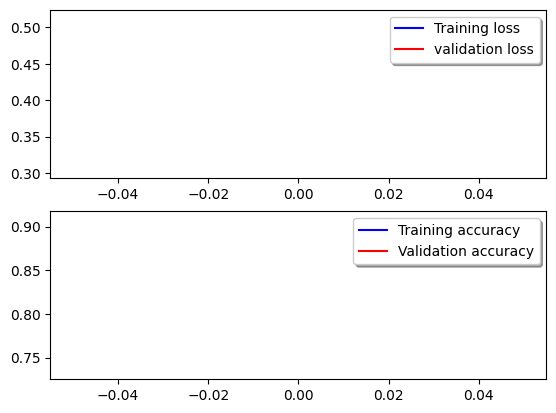

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
class_names = ['fake', 'real']
# After training the model, you can use X_val and Y_val for evaluation
Y_pred_val = model.predict(X_val)

# Convert predictions classes to one hot vectors
Y_pred_classes_val = np.argmax(Y_pred_val, axis=1)
# Convert validation observations to one hot vectors
Y_true_val = np.argmax(Y_val, axis=1)

# Calculate overall accuracy on validation set
overall_accuracy_val = accuracy_score(Y_true_val, Y_pred_classes_val)
print(f'Overall Accuracy on Validation Set: {overall_accuracy_val * 100:.2f}%')

# Calculate other metrics using classification_report
report_val = classification_report(Y_true_val, Y_pred_classes_val, target_names=class_names)
print('Classification Report on Validation Set:')
print(report_val)

# Calculate confusion matrix on validation set
conf_matrix_val = confusion_matrix(Y_true_val, Y_pred_classes_val)
print('Confusion Matrix on Validation Set:')
print(conf_matrix_val)

true_positive = conf_matrix_val[1, 1]
false_positive = conf_matrix_val[0, 1]
false_negative = conf_matrix_val[1, 0]
true_negative = conf_matrix_val[0, 0]

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR)
fpr = false_positive / (false_positive + true_negative)
fnr = false_negative / (false_negative + true_positive)

print(f'False Positive Rate (FPR): {fpr * 100:.2f}%')
print(f'False Negative Rate (FNR): {fnr * 100:.2f}%')

# Calculate Cohen's Kappa on validation set
cohen_kappa_val = cohen_kappa_score(Y_true_val, Y_pred_classes_val)
print(f'Cohen\'s Kappa on Validation Set: {cohen_kappa_val:.4f}')

27/27 [==============================] - 19s 706ms/step
Overall Accuracy on Validation Set: 90.88%
Classification Report on Validation Set:
              precision    recall  f1-score   support

        fake       0.88      0.95      0.91       407
        real       0.95      0.87      0.91       426

    accuracy                           0.91       833
   macro avg       0.91      0.91      0.91       833
weighted avg       0.91      0.91      0.91       833

Confusion Matrix on Validation Set:
[[386  21]
 [ 55 371]]
False Positive Rate (FPR): 5.16%
False Negative Rate (FNR): 12.91%
Cohen's Kappa on Validation Set: 0.8178


In [ ]:
import io
def upload_and_predict(model):
    uploaded = files.upload()

    for fn in uploaded.keys():
        # Display the uploaded image
        display(IPImage(data=uploaded[fn]))

        # Process the image and predict
        image_path = io.BytesIO(uploaded[fn])
        processed_image = prepare_image(image_path).reshape(-1, 128, 128, 3)
        prediction = model.predict(processed_image)
        predicted_class = np.argmax(prediction, axis=1)[0]
        print("Predicted Class:", "Real" if predicted_class == 1 else "Fake")

Saving fake_image_1.png to fake_image_1.png


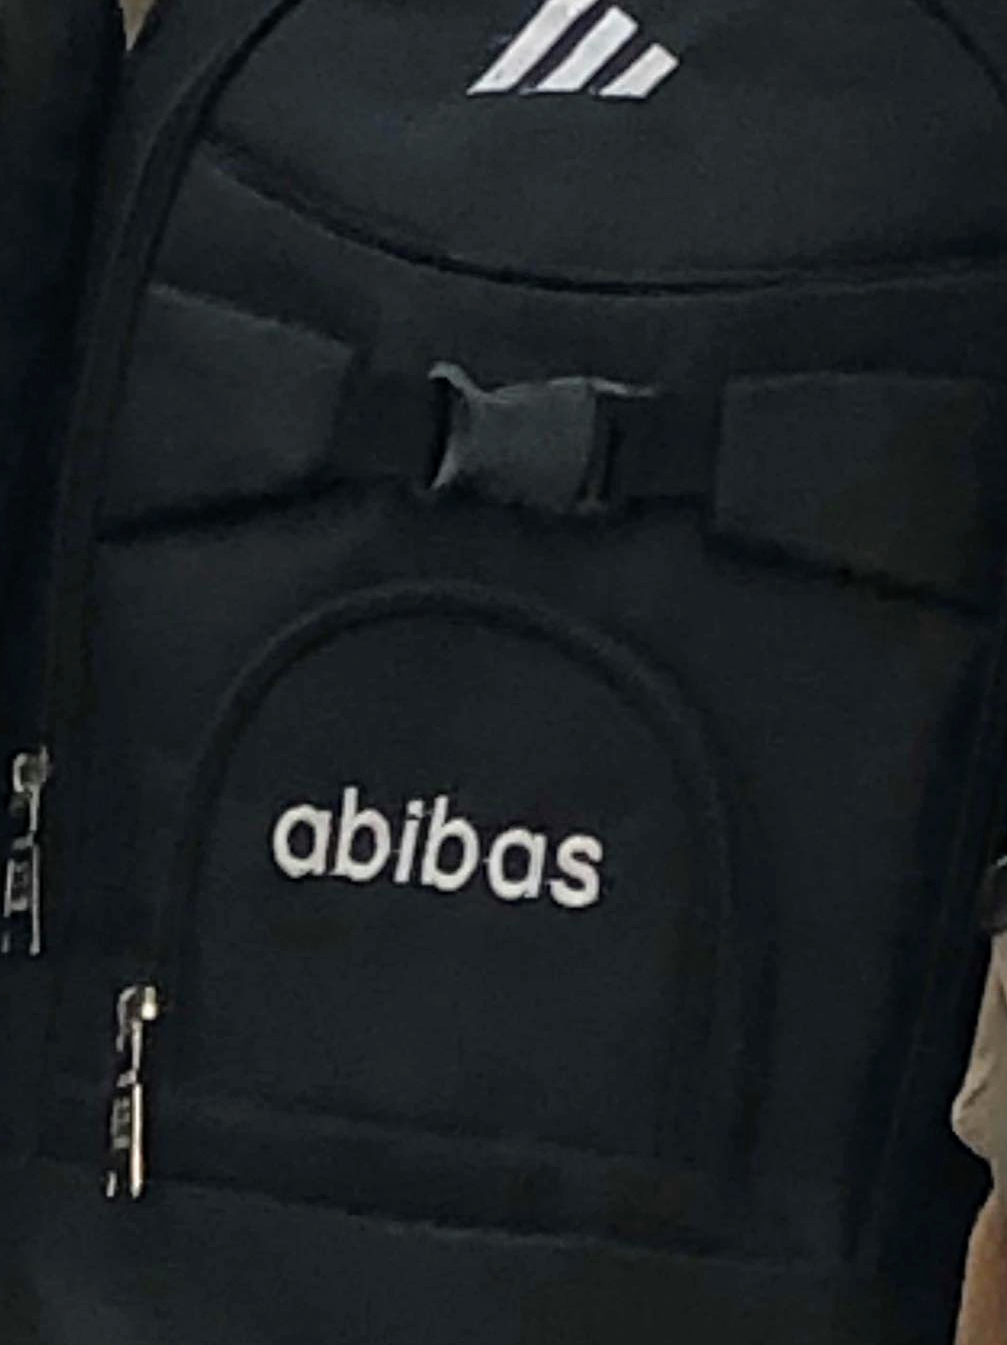

1/1 [==============================] - 0s 55ms/step
Predicted Class: Fake


In [ ]:
upload_and_predict(model)